In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder
from scipy import stats
from scipy.stats import zscore
from sklearn.neighbors import LocalOutlierFactor 
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier

In [42]:
df = pd.read_csv("housing_data_challenge.csv", delimiter=";")
df.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,18576.000000,18576.000000,18576.000000,18576.000000,18388.000000,18576.000000,18576.000000,18576.000000,18576.000000
mean,-119.563730,35.627052,28.657192,2633.559916,537.537524,1424.686746,498.951820,3.876364,206864.619671
std,2.001352,2.134321,12.614083,2175.784573,420.993441,1132.373751,381.328659,1.908169,115448.691679
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.780000,33.930000,18.000000,1444.000000,295.000000,788.000000,279.000000,2.564300,119400.000000
50%,-118.490000,34.250000,29.000000,2129.000000,434.500000,1167.000000,409.000000,3.534800,179700.000000
75%,-118.000000,37.710000,37.000000,3145.000000,645.000000,1724.000000,604.000000,4.750000,264700.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


# Exploring data

In [3]:
df.dtypes

longitude             float64
latitude              float64
housing_median_age    float64
total_rooms           float64
total_bedrooms        float64
population            float64
households            float64
median_income         float64
median_house_value    float64
ocean_proximity        object
dtype: object

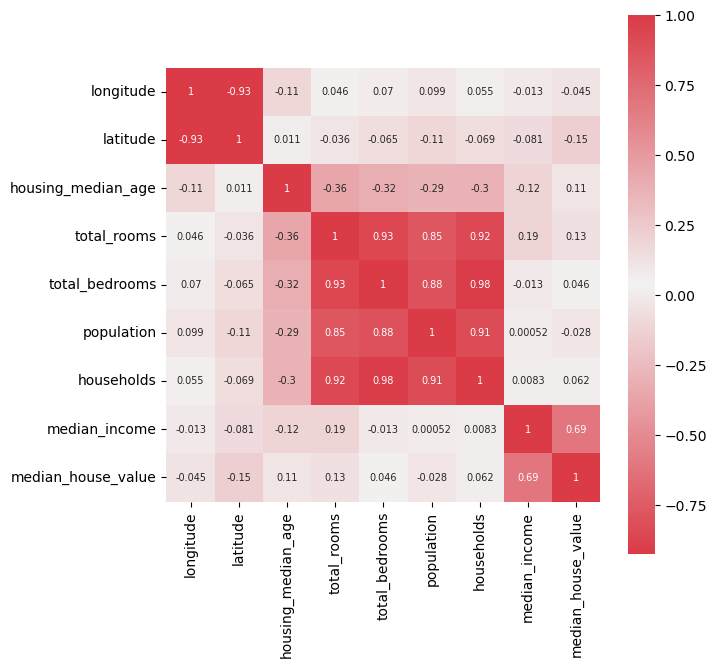

In [43]:
corrMatrix = df[df.select_dtypes(include=['float64', 'int64']).columns].corr()
plt.figure(figsize =(7,7))
plt.rc('font', size=7)
plt.rc('axes', labelsize=7, titlesize=7)
cmap = sns.diverging_palette(10, 10, as_cmap=True)
fig = sns.heatmap(corrMatrix , annot=True , square=True ,cmap=cmap)

# Feature engineering

In [4]:
#feature engineering
df['population_per_household'] = df['population'] / df['households']
df['bedrooms_per_room'] = df['total_bedrooms'] / df['total_rooms']
df['bedrooms_per_household'] = df['total_bedrooms'] / df['households']

One hot encoding the data here so we can use it in the model as this is categorical data

In [5]:
# One hot encoding
encoder = OneHotEncoder()
encoder.fit_transform(df[["ocean_proximity"]])

feature_array = encoder.fit_transform(df[["ocean_proximity"]]).toarray()
feature_labels = encoder.categories_

ohe_ocean = pd.DataFrame(feature_array, columns = feature_labels)
df = pd.concat([df, ohe_ocean], axis = 1)

df = df.drop("ocean_proximity", axis=1)
df.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,population_per_household,bedrooms_per_room,bedrooms_per_household,"(<1H OCEAN,)","(INLAND,)","(ISLAND,)","(NEAR BAY,)","(NEAR OCEAN,)"
count,18576.000000,18576.000000,18576.000000,18576.000000,18388.000000,18576.000000,18576.000000,18576.000000,18576.000000,18576.000000,18388.000000,18388.000000,18576.000000,18576.000000,18576.000000,18576.000000,18576.000000
mean,-119.563730,35.627052,28.657192,2633.559916,537.537524,1424.686746,498.951820,3.876364,206864.619671,3.088248,0.213056,1.096199,0.441914,0.318260,0.000269,0.111003,0.128553
std,2.001352,2.134321,12.614083,2175.784573,420.993441,1132.373751,381.328659,1.908169,115448.691679,10.944105,0.058312,0.421179,0.496628,0.465814,0.016404,0.314145,0.334714
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000,0.692308,0.100000,0.333333,0.000000,0.000000,0.000000,0.000000,0.000000
25%,-121.780000,33.930000,18.000000,1444.000000,295.000000,788.000000,279.000000,2.564300,119400.000000,2.430995,0.175278,1.006118,0.000000,0.000000,0.000000,0.000000,0.000000
50%,-118.490000,34.250000,29.000000,2129.000000,434.500000,1167.000000,409.000000,3.534800,179700.000000,2.821980,0.203087,1.048944,0.000000,0.000000,0.000000,0.000000,0.000000
75%,-118.000000,37.710000,37.000000,3145.000000,645.000000,1724.000000,604.000000,4.750000,264700.000000,3.288181,0.239837,1.099664,1.000000,1.000000,0.000000,0.000000,0.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000,1243.333333,1.000000,25.636364,1.000000,1.000000,1.000000,1.000000,1.000000


In [6]:
print(df.isnull().sum())
df.dropna(subset=["total_bedrooms", "bedrooms_per_room", "bedrooms_per_household"], inplace=True)
df.isnull().sum()

longitude                     0
latitude                      0
housing_median_age            0
total_rooms                   0
total_bedrooms              188
population                    0
households                    0
median_income                 0
median_house_value            0
population_per_household      0
bedrooms_per_room           188
bedrooms_per_household      188
(<1H OCEAN,)                  0
(INLAND,)                     0
(ISLAND,)                     0
(NEAR BAY,)                   0
(NEAR OCEAN,)                 0
dtype: int64


longitude                   0
latitude                    0
housing_median_age          0
total_rooms                 0
total_bedrooms              0
population                  0
households                  0
median_income               0
median_house_value          0
population_per_household    0
bedrooms_per_room           0
bedrooms_per_household      0
(<1H OCEAN,)                0
(INLAND,)                   0
(ISLAND,)                   0
(NEAR BAY,)                 0
(NEAR OCEAN,)               0
dtype: int64

Checking for outliers.

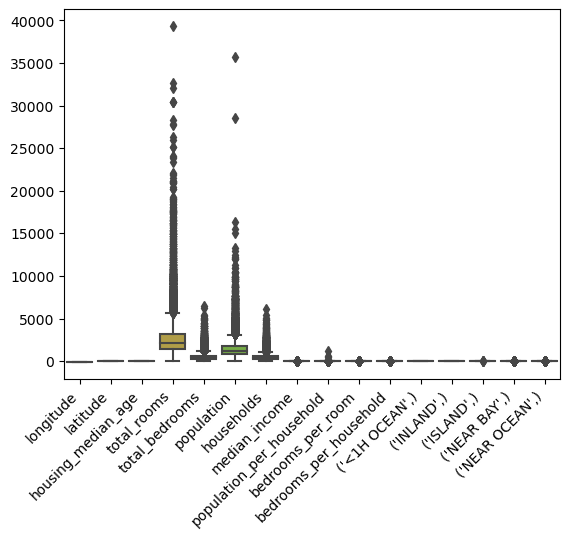

In [7]:
sns.boxplot(data=df.drop("median_house_value", axis = 1, inplace = False))

# Slant the x-axis labels
plt.xticks(rotation=45, ha="right")
plt.show()

Here I used z-score as 2 and -2 as for my data this works well, when I had the z-score as 3 and -3, all the outliers were not removed.

In [8]:
# outlier management
def detect_and_remove_outliers(data, features): 
    
    _data = data
    
    for feature in features:
        # Calculate Z-scores     
        z_scores = stats.zscore(data[feature])  
        print(type(z_scores))
        # Identify outliers     
        outliers = (z_scores > 2) | (z_scores < -2)     
        
        # Remove outliers   
        _data = data
        data = data[~outliers]      
        
        # Print outlier information     
        number_of_outliers = len(_data[outliers])     
        percentage_of_outliers = round(number_of_outliers / len(_data) * 100, 2)     
        print("Outlier of {} are anything outside this range: ({},{})".format(feature, z_scores.min(),z_scores.max()))  
        print("The earlier min, max were: ({},{})".format(_data[feature].min(), _data[feature].max()))
        print("The current min, max are: ({},{})".format(data[feature].min(), data[feature].max()))
        print("Outliers out of total = {} are \n {}".format(len(_data),len(_data[outliers])))  
        
    return _data  


df.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,population_per_household,bedrooms_per_room,bedrooms_per_household,"(<1H OCEAN,)","(INLAND,)","(ISLAND,)","(NEAR BAY,)","(NEAR OCEAN,)"
count,18388.000000,18388.000000,18388.000000,18388.000000,18388.000000,18388.000000,18388.000000,18388.000000,18388.000000,18388.000000,18388.000000,18388.000000,18388.000000,18388.000000,18388.000000,18388.000000,18388.000000
mean,-119.564858,35.628460,28.649554,2634.645040,537.537524,1424.294975,498.928758,3.877095,206905.877148,3.089202,0.213056,1.096199,0.441212,0.318904,0.000272,0.111214,0.128399
std,2.001363,2.134489,12.620395,2179.311775,420.993441,1133.117648,381.288321,1.907455,115525.794935,10.999669,0.058312,0.421179,0.496545,0.466064,0.016488,0.314405,0.334543
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000,0.692308,0.100000,0.333333,0.000000,0.000000,0.000000,0.000000,0.000000
25%,-121.780000,33.930000,18.000000,1446.000000,295.000000,788.000000,279.000000,2.564300,119400.000000,2.430323,0.175278,1.006118,0.000000,0.000000,0.000000,0.000000,0.000000
50%,-118.490000,34.250000,29.000000,2129.000000,434.500000,1167.000000,409.000000,3.536450,179800.000000,2.820594,0.203087,1.048944,0.000000,0.000000,0.000000,0.000000,0.000000
75%,-118.000000,37.710000,37.000000,3141.250000,645.000000,1722.000000,603.000000,4.750000,264700.000000,3.287246,0.239837,1.099664,1.000000,1.000000,0.000000,0.000000,0.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000,1243.333333,1.000000,25.636364,1.000000,1.000000,1.000000,1.000000,1.000000


In [9]:
num_features = df.drop("median_house_value", axis = 1, inplace = False).select_dtypes(include=['float64', 'int64']).columns
features = ["total_rooms", "total_bedrooms", "population", "households", "median_income"]
df = detect_and_remove_outliers(df, num_features) 

<class 'pandas.core.series.Series'>
Outlier of longitude are anything outside this range: (-2.391007402239751,2.625711409709238)
The earlier min, max were: (-124.35,-114.31)
The current min, max are: (-123.54,-115.57)
Outliers out of total = 18388 are 
 232
<class 'pandas.core.series.Series'>
Outlier of latitude are anything outside this range: (-1.4626250148366422,3.0363989742291846)
The earlier min, max were: (32.54,41.95)
The current min, max are: (32.54,39.78)
Outliers out of total = 18156 are 
 271
<class 'pandas.core.series.Series'>
Outlier of housing_median_age are anything outside this range: (-2.1935858433818898,1.836308201651534)
The earlier min, max were: (1.0,52.0)
The current min, max are: (4.0,52.0)
Outliers out of total = 17885 are 
 112
<class 'pandas.core.series.Series'>
Outlier of total_rooms are anything outside this range: (-1.236117173207733,14.13987054188394)
The earlier min, max were: (2.0,32627.0)
The current min, max are: (2.0,6862.0)
Outliers out of total = 17

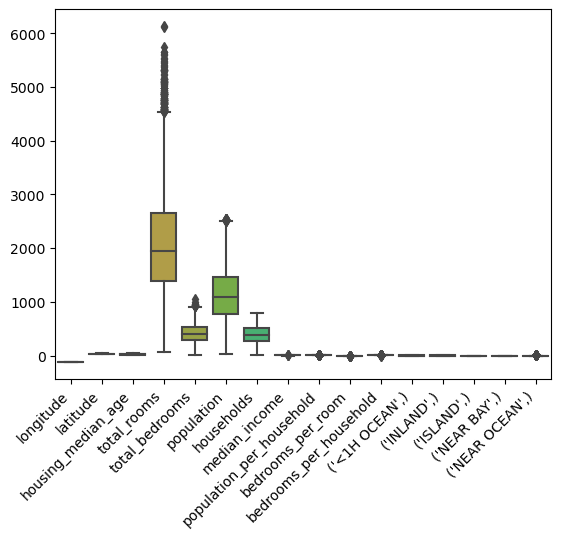

In [10]:
sns.boxplot(data=df.drop("median_house_value", axis = 1, inplace = False))

# Slant the x-axis labels
plt.xticks(rotation=45, ha="right")
plt.show()

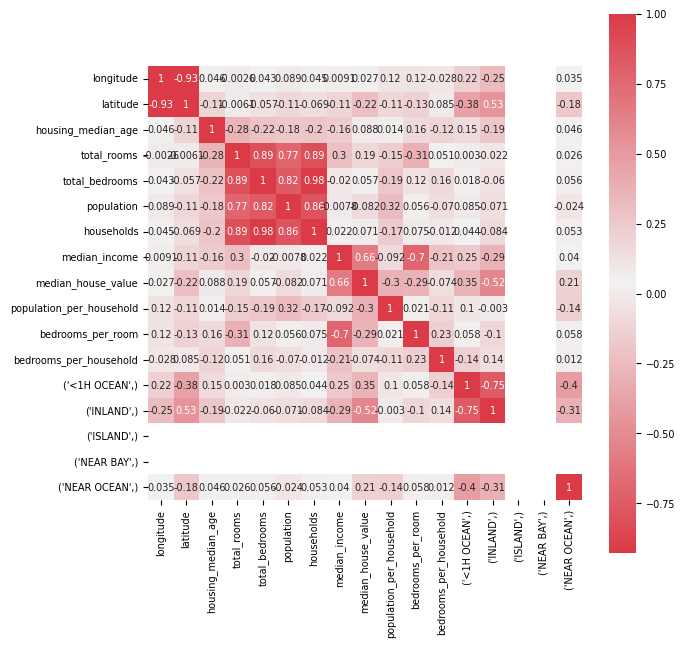

In [11]:
# feature selection

corrMatrix = df[df.select_dtypes(include=['float64', 'int64']).columns].corr()
plt.figure(figsize =(7,7))
plt.rc('font', size=7)
plt.rc('axes', labelsize=7, titlesize=7)
cmap = sns.diverging_palette(10, 10, as_cmap=True)
fig = sns.heatmap(corrMatrix , annot=True , square=True ,cmap=cmap)

Here I am removing "total_rooms" and "population" because they are highly correlated and also because total_bedrooms has too many outliers. In my opinion, latitude and longitude do not give us a lot of information, so I am deleting those too. Median household is not beneficial here as it's correlation with median_house_value is low.

In [12]:
del_columns = ["total_rooms", "population", "bedrooms_per_household", "latitude", "longitude"]#, "ocean_proximity"]
df.drop(del_columns, axis = 1, inplace = True)
#, "latitude", "longitude"

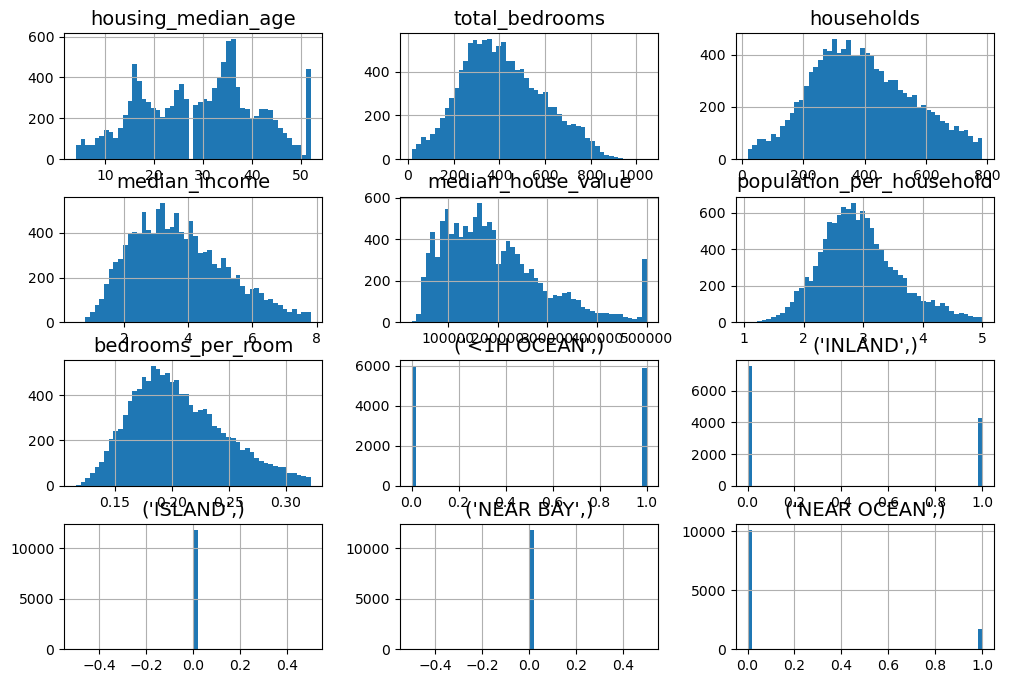

In [13]:
plt.rc('font', size=14)
plt.rc('axes', labelsize=14, titlesize=14)
plt.rc('legend', fontsize=14)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)

df.hist(bins=50, figsize=(12, 8))
plt.show()

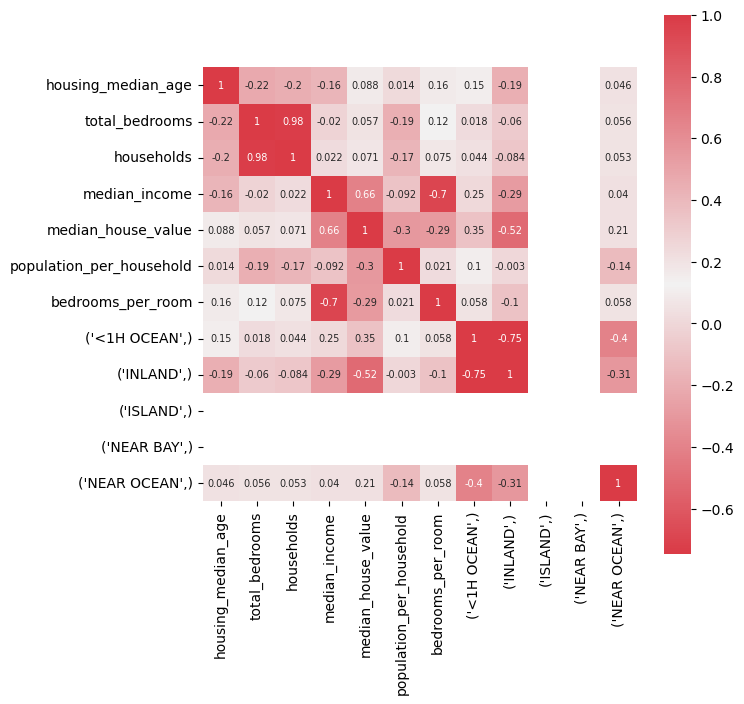

In [14]:
corrMatrix = df[df.select_dtypes(include=['float64', 'int64']).columns].corr()
plt.figure(figsize =(7,7))
plt.rc('font', size=7)
plt.rc('axes', labelsize=7, titlesize=7)
cmap = sns.diverging_palette(10, 10, as_cmap=True)
fig = sns.heatmap(corrMatrix , annot=True , square=True ,cmap=cmap)

In [15]:
df.columns = df.columns.astype(str)

# Test, train split

In [16]:
train, test = train_test_split(df, test_size=0.2, random_state=42)

In [17]:
train

,housing_median_age,total_bedrooms,households,median_income,median_house_value,population_per_household,bedrooms_per_room,"('<1H OCEAN',)","('INLAND',)","('ISLAND',)","('NEAR BAY',)","('NEAR OCEAN',)"
1851,52.0,245.0,226.0,2.2639,128500.0,2.336283,0.217972,0.0,1.0,0.0,0.0,0.0
14943,52.0,377.0,356.0,2.0958,116400.0,2.758427,0.223606,1.0,0.0,0.0,0.0,0.0
8741,26.0,535.0,532.0,2.6893,230800.0,2.599624,0.187785,1.0,0.0,0.0,0.0,0.0
18261,35.0,357.0,359.0,5.2162,171900.0,3.417827,0.183548,1.0,0.0,0.0,0.0,0.0
9031,37.0,361.0,363.0,3.7932,210300.0,2.856749,0.180771,0.0,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
17684,31.0,575.0,549.0,3.6667,175900.0,2.688525,0.187663,0.0,0.0,0.0,0.0,1.0
8102,34.0,212.0,201.0,3.8828,215400.0,3.363184,0.157387,1.0,0.0,0.0,0.0,0.0
8414,22.0,335.0,308.0,2.6033,121600.0,2.269481,0.268215,1.0,0.0,0.0,0.0,0.0
1292,15.0,401.0,429.0,3.0278,77400.0,2.885781,0.175262,0.0,1.0,0.0,0.0,0.0


In [18]:
train.describe()

,housing_median_age,total_bedrooms,households,median_income,median_house_value,population_per_household,bedrooms_per_room,"('<1H OCEAN',)","('INLAND',)","('ISLAND',)","('NEAR BAY',)","('NEAR OCEAN',)"
count,9476.000000,9476.000000,9476.000000,9476.000000,9476.000000,9476.000000,9476.000000,9476.000000,9476.000000,9476.0,9476.0,9476.000000
mean,29.235542,413.246940,390.988075,3.735658,194249.209371,2.942057,0.206119,0.493668,0.364922,0.0,0.0,0.141410
std,11.648494,179.393012,165.672183,1.461044,103580.156755,0.655536,0.041043,0.499986,0.481434,0.0,0.0,0.348462
min,4.000000,16.000000,18.000000,0.549500,26600.000000,1.060606,0.116477,0.000000,0.000000,0.0,0.0,0.000000
25%,19.000000,281.750000,271.000000,2.621775,114400.000000,2.489855,0.175666,0.000000,0.000000,0.0,0.0,0.000000
50%,30.000000,395.000000,377.000000,3.557400,173750.000000,2.877099,0.200201,0.000000,0.000000,0.0,0.0,0.000000
75%,37.000000,535.000000,505.000000,4.679625,247425.000000,3.316070,0.232200,1.000000,1.000000,0.0,0.0,0.000000
max,52.000000,1044.000000,784.000000,7.816400,500001.000000,4.995816,0.321300,1.000000,1.000000,0.0,0.0,1.000000


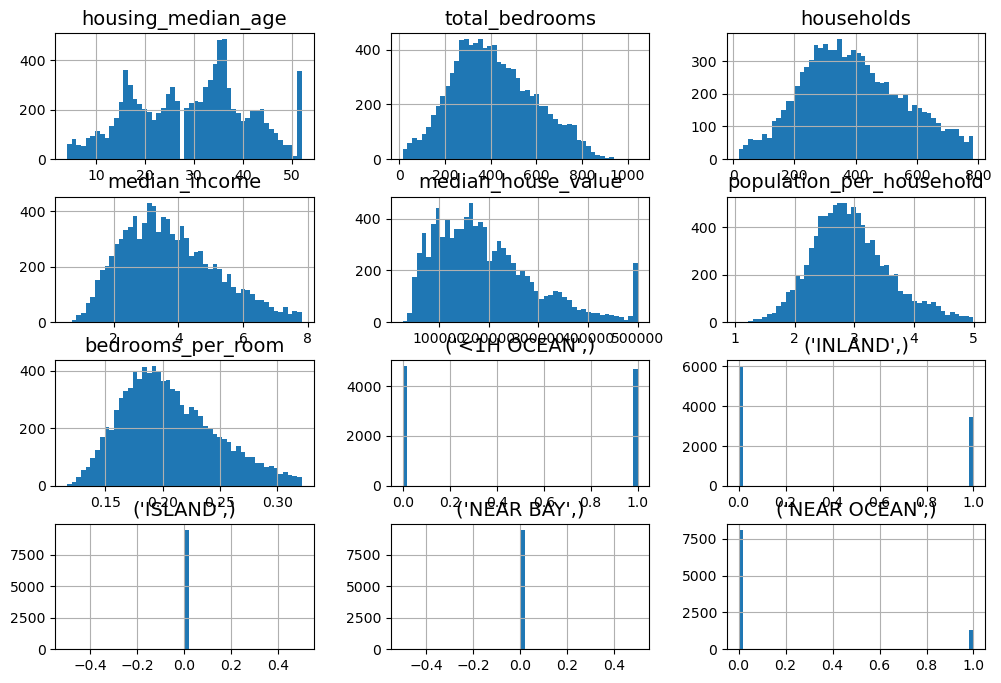

In [19]:
plt.rc('font', size=14)
plt.rc('axes', labelsize=14, titlesize=14)
plt.rc('legend', fontsize=14)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)

train.hist(bins=50, figsize=(12, 8))
plt.show()

In [20]:
# standardization
y_train = train["median_house_value"]
x_train = train.drop("median_house_value", axis = 1, inplace = False)

Scaling the data so it can be easily computed by the machine.

In [21]:
cols = x_train.columns

scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)

x_train = pd.DataFrame(x_train, columns=cols)

Fit and transform only the training set and transform the test set to avoid data leakage.

In [22]:
y_test = test["median_house_value"]
x_test = test.drop("median_house_value", axis = 1, inplace = False)
cols = x_test.columns
x_test = scaler.transform(x_test)
x_test = pd.DataFrame(x_test, columns=cols)
print(cols)
x_test

Index(['housing_median_age', 'total_bedrooms', 'households', 'median_income',
       'population_per_household', 'bedrooms_per_room', '('<1H OCEAN',)',
       '('INLAND',)', '('ISLAND',)', '('NEAR BAY',)', '('NEAR OCEAN',)'],
      dtype='object')


,housing_median_age,total_bedrooms,households,median_income,population_per_household,bedrooms_per_room,"('<1H OCEAN',)","('INLAND',)","('ISLAND',)","('NEAR BAY',)","('NEAR OCEAN',)"
0,0.237336,0.238333,0.561451,0.708532,-0.485263,0.005268,1.012745,-0.758030,0.0,0.0,-0.405833
1,-1.823125,0.366550,-0.410399,-0.182658,-0.313066,1.195784,-0.987416,1.319209,0.0,0.0,-0.405833
2,0.065631,0.996485,1.448792,-0.134745,0.545335,-0.496191,-0.987416,-0.758030,0.0,0.0,2.464070
3,-1.308010,1.654294,1.895481,0.032884,0.196590,0.717549,1.012745,-0.758030,0.0,0.0,-0.405833
4,0.838303,-0.335855,-0.277599,-1.453734,0.689771,1.660855,1.012745,-0.758030,0.0,0.0,-0.405833
...,...,...,...,...,...,...,...,...,...,...,...
2365,0.580746,-0.458498,-0.476798,-0.072868,2.855900,0.617677,1.012745,-0.758030,0.0,0.0,-0.405833
2366,-0.020222,-1.378314,-1.376212,0.838651,1.099189,-0.472506,1.012745,-0.758030,0.0,0.0,-0.405833
2367,-1.994830,-2.158765,-2.215263,-0.004420,-0.102299,0.736951,-0.987416,1.319209,0.0,0.0,-0.405833
2368,1.782681,-0.731655,-0.808797,-0.709501,1.916681,0.536948,1.012745,-0.758030,0.0,0.0,-0.405833


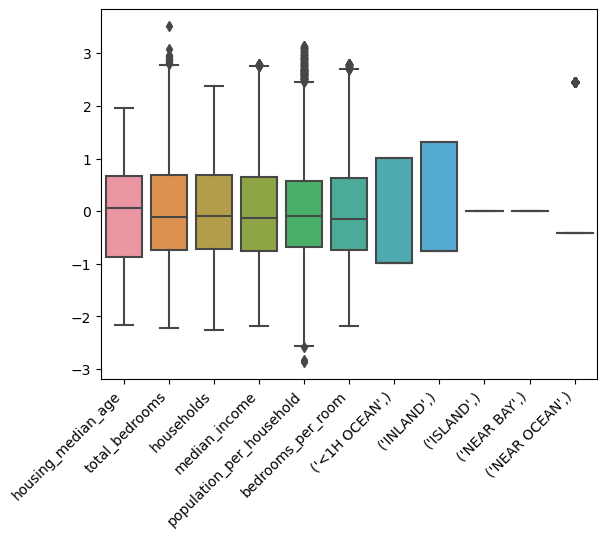

In [23]:
sns.boxplot(data=x_train)

# Slant the x-axis labels
plt.xticks(rotation=45, ha="right")
plt.show()

<Axes: >

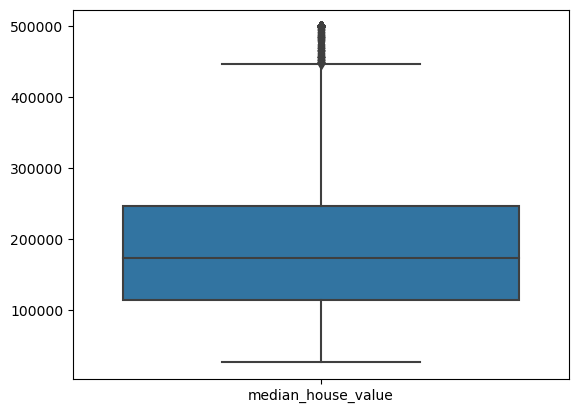

In [24]:
sns.boxplot(data=train[["median_house_value"]])

# Training the model

In [25]:
# training model
param_grid = {
    'n_estimators': [100, 300, 500, 1000],
    'max_depth': [10, 15, 20, 50],
    'min_samples_split':[1,2,4,8],
    'max_features':['sqrt','n/3','log2']
}
rfc_model = RandomForestRegressor()
grid_cv = GridSearchCV ( estimator = rfc_model, param_grid = param_grid, scoring ='neg_mean_squared_error', cv = 2, verbose = 3)

In [26]:
grid_cv.fit(x_train, y_train)

Fitting 2 folds for each of 192 candidates, totalling 384 fits
[CV 1/2] END max_depth=10, max_features=sqrt, min_samples_split=1, n_estimators=100;, score=nan total time=   0.0s
[CV 2/2] END max_depth=10, max_features=sqrt, min_samples_split=1, n_estimators=100;, score=nan total time=   0.0s
[CV 1/2] END max_depth=10, max_features=sqrt, min_samples_split=1, n_estimators=300;, score=nan total time=   0.0s
[CV 2/2] END max_depth=10, max_features=sqrt, min_samples_split=1, n_estimators=300;, score=nan total time=   0.0s
[CV 1/2] END max_depth=10, max_features=sqrt, min_samples_split=1, n_estimators=500;, score=nan total time=   0.0s
[CV 2/2] END max_depth=10, max_features=sqrt, min_samples_split=1, n_estimators=500;, score=nan total time=   0.0s
[CV 1/2] END max_depth=10, max_features=sqrt, min_samples_split=1, n_estimators=1000;, score=nan total time=   0.0s
[CV 2/2] END max_depth=10, max_features=sqrt, min_samples_split=1, n_estimators=1000;, score=nan total time=   0.0s
[CV 1/2] END ma

[CV 1/2] END max_depth=10, max_features=log2, min_samples_split=2, n_estimators=100;, score=-3269858589.796 total time=   5.0s
[CV 2/2] END max_depth=10, max_features=log2, min_samples_split=2, n_estimators=100;, score=-3329521141.615 total time=   5.0s
[CV 1/2] END max_depth=10, max_features=log2, min_samples_split=2, n_estimators=300;, score=-3202772789.913 total time=  14.1s
[CV 2/2] END max_depth=10, max_features=log2, min_samples_split=2, n_estimators=300;, score=-3327365963.131 total time=  15.0s
[CV 1/2] END max_depth=10, max_features=log2, min_samples_split=2, n_estimators=500;, score=-3204948118.484 total time=  25.0s
[CV 2/2] END max_depth=10, max_features=log2, min_samples_split=2, n_estimators=500;, score=-3311145203.821 total time=  25.0s
[CV 1/2] END max_depth=10, max_features=log2, min_samples_split=2, n_estimators=1000;, score=-3202900680.015 total time=  51.2s
[CV 2/2] END max_depth=10, max_features=log2, min_samples_split=2, n_estimators=1000;, score=-3314918326.771 t

[CV 1/2] END max_depth=15, max_features=log2, min_samples_split=1, n_estimators=1000;, score=nan total time=   0.0s
[CV 2/2] END max_depth=15, max_features=log2, min_samples_split=1, n_estimators=1000;, score=nan total time=   0.0s
[CV 1/2] END max_depth=15, max_features=log2, min_samples_split=2, n_estimators=100;, score=-3192167480.140 total time=   7.6s
[CV 2/2] END max_depth=15, max_features=log2, min_samples_split=2, n_estimators=100;, score=-3274125861.267 total time=   7.5s
[CV 1/2] END max_depth=15, max_features=log2, min_samples_split=2, n_estimators=300;, score=-3141842271.200 total time=  22.1s
[CV 2/2] END max_depth=15, max_features=log2, min_samples_split=2, n_estimators=300;, score=-3265392853.251 total time=  22.5s
[CV 1/2] END max_depth=15, max_features=log2, min_samples_split=2, n_estimators=500;, score=-3147382819.064 total time=  37.2s
[CV 2/2] END max_depth=15, max_features=log2, min_samples_split=2, n_estimators=500;, score=-3255199995.157 total time=  37.6s
[CV 1/

[CV 1/2] END max_depth=20, max_features=log2, min_samples_split=1, n_estimators=500;, score=nan total time=   0.0s
[CV 2/2] END max_depth=20, max_features=log2, min_samples_split=1, n_estimators=500;, score=nan total time=   0.0s
[CV 1/2] END max_depth=20, max_features=log2, min_samples_split=1, n_estimators=1000;, score=nan total time=   0.0s
[CV 2/2] END max_depth=20, max_features=log2, min_samples_split=1, n_estimators=1000;, score=nan total time=   0.0s
[CV 1/2] END max_depth=20, max_features=log2, min_samples_split=2, n_estimators=100;, score=-3182843060.945 total time=   9.0s
[CV 2/2] END max_depth=20, max_features=log2, min_samples_split=2, n_estimators=100;, score=-3292760636.101 total time=   8.4s
[CV 1/2] END max_depth=20, max_features=log2, min_samples_split=2, n_estimators=300;, score=-3152393649.140 total time=  25.4s
[CV 2/2] END max_depth=20, max_features=log2, min_samples_split=2, n_estimators=300;, score=-3249720914.427 total time=  26.8s
[CV 1/2] END max_depth=20, max

[CV 2/2] END max_depth=50, max_features=log2, min_samples_split=1, n_estimators=1000;, score=nan total time=   0.0s
[CV 1/2] END max_depth=50, max_features=log2, min_samples_split=2, n_estimators=100;, score=-3167045574.293 total time=   8.6s
[CV 2/2] END max_depth=50, max_features=log2, min_samples_split=2, n_estimators=100;, score=-3257835922.158 total time=   8.7s
[CV 1/2] END max_depth=50, max_features=log2, min_samples_split=2, n_estimators=300;, score=-3163513274.584 total time=  26.8s
[CV 2/2] END max_depth=50, max_features=log2, min_samples_split=2, n_estimators=300;, score=-3266147052.498 total time=  26.0s
[CV 1/2] END max_depth=50, max_features=log2, min_samples_split=2, n_estimators=500;, score=-3149633414.531 total time=  45.2s
[CV 2/2] END max_depth=50, max_features=log2, min_samples_split=2, n_estimators=500;, score=-3255834564.373 total time=  44.7s
[CV 1/2] END max_depth=50, max_features=log2, min_samples_split=2, n_estimators=1000;, score=-3148736316.785 total time= 1

C:\Users\Ananya Gyanmote\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:425: FitFailedWarning: 
192 fits failed out of a total of 384.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
64 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\Ananya Gyanmote\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 732, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Ananya Gyanmote\anaconda3\Lib\site-packages\sklearn\base.py", line 1144, in wrapper
    estimator._validate_params()
  File "C:\Users\Ananya Gyanmote\anaconda3\Lib\site-packages\sklearn\base.py", line 637, in _validate_params
    validate_parameter_constraints(
  File "C

GridSearchCV(cv=2, estimator=RandomForestRegressor(),
             param_grid={'max_depth': [10, 15, 20, 50],
                         'max_features': ['sqrt', 'n/3', 'log2'],
                         'min_samples_split': [1, 2, 4, 8],
                         'n_estimators': [100, 300, 500, 1000]},
             scoring='neg_mean_squared_error', verbose=3)

# Evaluating the model

In [29]:
# model evaluation
print(grid_cv.best_estimator_)
print(grid_cv.best_params_)

y_pred = grid_cv.predict(x_test)

RandomForestRegressor(max_depth=50, max_features='log2', min_samples_split=4,
                      n_estimators=300)
{'max_depth': 50, 'max_features': 'log2', 'min_samples_split': 4, 'n_estimators': 300}


In [30]:
np.sqrt(mean_squared_error(y_test,y_pred))

56339.75630556025

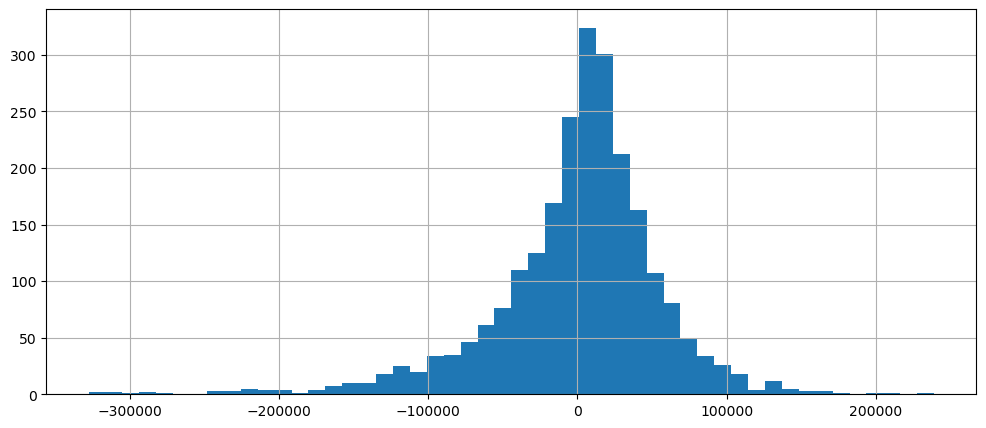

In [52]:
diff = y_pred - y_test

plt.rc('font', size=14)
plt.rc('axes', labelsize=14, titlesize=14)
plt.rc('legend', fontsize=14)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)

diff.hist(bins=50, figsize=(12, 5))
plt.show()

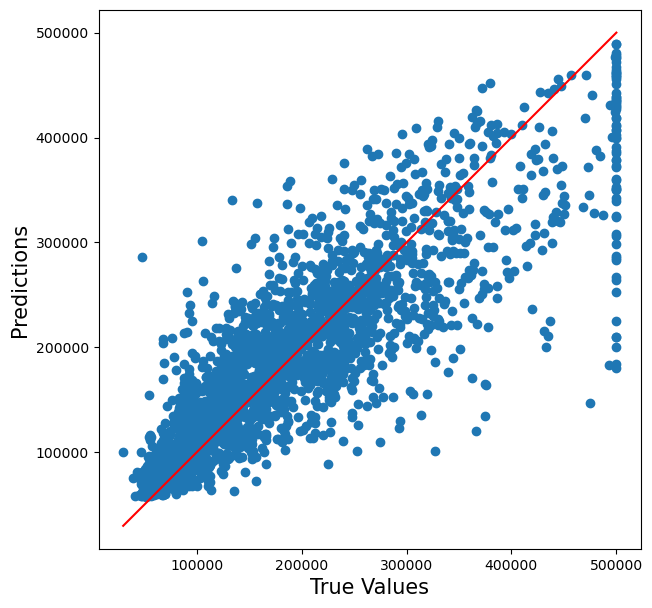

In [59]:
plt.figure(figsize=(7,7))
plt.scatter(y_test, y_pred)
#plt.yscale('log')
#plt.xscale('log')

p1 = max(max(y_pred), max(y_test))
p2 = min(min(y_pred), min(y_test))
plt.plot([p1, p2], [p1, p2], 'r')
plt.xlabel('True Values', fontsize=15)
plt.ylabel('Predictions', fontsize=15)
plt.axis('equal')
plt.show()

So, our rmse for the best model is 56,339. That means on an average our model has an error on 56,339.